# Matheus_Schmitz_hw7_task_1

Matheus Schmitz

USC ID: 5039286453

In [1]:
# File manipulation imports for Google Colab
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/My Drive/Colab Notebooks/DSCI 558")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


https://docs.ampligraph.org/en/1.3.2/tutorials/AmpliGraphBasicsTutorial.html

In [2]:
!pip install -q ampligraph
!pip install -q tensorflow==1.15

In [3]:
import requests
from ampligraph.datasets import load_from_csv
import numpy as np

## 1. Dataset exploration

In [4]:
url = 'https://ampligraph.s3-eu-west-1.amazonaws.com/datasets/GoT.csv'
with open('GoT.csv', 'wb') as f_in:
    f_in.write(requests.get(url).content)

In [5]:
X = load_from_csv('.', 'GoT.csv', sep=',')
X[:5, ]

array([['Smithyton', 'SEAT_OF', 'House Shermer of Smithyton'],
       ['House Mormont of Bear Island', 'LED_BY', 'Maege Mormont'],
       ['Margaery Tyrell', 'SPOUSE', 'Joffrey Baratheon'],
       ['Maron Nymeros Martell', 'ALLIED_WITH',
        'House Nymeros Martell of Sunspear'],
       ['House Gargalen of Salt Shore', 'IN_REGION', 'Dorne']],
      dtype=object)

In [6]:
entities = np.unique(np.concatenate([X[:, 0], X[:, 2]]))
entities

array(['Abelar Hightower', 'Acorn Hall', 'Addam Frey', ..., 'the Antlers',
       'the Paps', 'unnamed tower'], dtype=object)

In [7]:
relations = np.unique(X[:, 1])
relations

array(['ALLIED_WITH', 'BRANCH_OF', 'FOUNDED_BY', 'HEIR_TO', 'IN_REGION',
       'LED_BY', 'PARENT_OF', 'SEAT_OF', 'SPOUSE', 'SWORN_TO'],
      dtype=object)

## 2. Defining train and test datasets

In [8]:
from ampligraph.evaluation import train_test_split_no_unseen 

X_train, X_test = train_test_split_no_unseen(X, test_size=100) 
print('Train set size: ', X_train.shape)
print('Test set size: ', X_test.shape)

Train set size:  (3075, 3)
Test set size:  (100, 3)


## 3. Training a model (ComplEx)


In [9]:
from ampligraph.latent_features import ComplEx

In [10]:
model = ComplEx(batches_count=100, 
                seed=0, 
                epochs=200, 
                k=150, 
                eta=5,
                optimizer='adam', 
                optimizer_params={'lr':1e-3},
                loss='multiclass_nll', 
                regularizer='LP', 
                regularizer_params={'p':3, 'lambda':1e-5}, 
                verbose=True)

### Filtering negatives

In [11]:
positives_filter = X

### Fitting the model

In [12]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

model.fit(X_train, early_stopping = False)

Average Loss:   0.017603: 100%|██████████| 200/200 [03:25<00:00,  1.03s/epoch]


## 4. Saving and restoring a model

In [13]:
from ampligraph.latent_features import save_model, restore_model

In [14]:
save_model(model, './best_model.pkl')

In [15]:
del model

In [16]:
model = restore_model('./best_model.pkl')

In [17]:
if model.is_fitted:
    print('The model is fit!')
else:
    print('The model is not fit! Did you skip a step?')

The model is fit!


## 5. Evaluating a model

In [18]:
from ampligraph.evaluation import evaluate_performance

### Running evaluation

In [19]:
ranks = evaluate_performance(X_test, 
                             model=model, 
                             filter_triples=positives_filter,   # Corruption strategy filter defined above 
                             use_default_protocol=True, # corrupt subj and obj separately while evaluating
                             verbose=True)

WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.


100%|██████████| 100/100 [00:01<00:00, 62.33it/s]


### Metrics

In [20]:
# Dictionary to compare performances of different models
model_comparison = {}

In [21]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

model_comparison['ComplEx'] = {}
model_comparison['ComplEx']['MMR'] = mrr_score(ranks)
print("MRR: %.2f" % (model_comparison['ComplEx']['MMR']))

model_comparison['ComplEx']['Hits@10'] = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (model_comparison['ComplEx']['Hits@10']))
model_comparison['ComplEx']['Hits@3'] = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (model_comparison['ComplEx']['Hits@3']))
model_comparison['ComplEx']['Hits@1'] = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (model_comparison['ComplEx']['Hits@1']))

MRR: 0.41
Hits@10: 0.55
Hits@3: 0.45
Hits@1: 0.34


## 6. Predicting New Links

In [22]:
X_unseen = np.array([
    ['Jorah Mormont', 'SPOUSE', 'Daenerys Targaryen'],
    ['Tyrion Lannister', 'SPOUSE', 'Missandei'],
    ["King's Landing", 'SEAT_OF', 'House Lannister of Casterly Rock'],
    ['Sansa Stark', 'SPOUSE', 'Petyr Baelish'],
    ['Daenerys Targaryen', 'SPOUSE', 'Jon Snow'],
    ['Daenerys Targaryen', 'SPOUSE', 'Craster'],
    ['House Stark of Winterfell', 'IN_REGION', 'The North'],
    ['House Stark of Winterfell', 'IN_REGION', 'Dorne'],
    ['House Tyrell of Highgarden', 'IN_REGION', 'Beyond the Wall'],
    ['Brandon Stark', 'ALLIED_WITH', 'House Stark of Winterfell'],
    ['Brandon Stark', 'ALLIED_WITH', 'House Lannister of Casterly Rock'],    
    ['Rhaegar Targaryen', 'PARENT_OF', 'Jon Snow'],
    ['House Hutcheson', 'SWORN_TO', 'House Tyrell of Highgarden'],
    ['Daenerys Targaryen', 'ALLIED_WITH', 'House Stark of Winterfell'],
    ['Daenerys Targaryen', 'ALLIED_WITH', 'House Lannister of Casterly Rock'],
    ['Jaime Lannister', 'PARENT_OF', 'Myrcella Baratheon'],
    ['Robert I Baratheon', 'PARENT_OF', 'Myrcella Baratheon'],
    ['Cersei Lannister', 'PARENT_OF', 'Myrcella Baratheon'],
    ['Cersei Lannister', 'PARENT_OF', 'Brandon Stark'],
    ["Tywin Lannister", 'PARENT_OF', 'Jaime Lannister'],
    ["Missandei", 'SPOUSE', 'Grey Worm'],
    ["Brienne of Tarth", 'SPOUSE', 'Jaime Lannister']
])

In [23]:
unseen_filter = np.array(list({tuple(i) for i in np.vstack((positives_filter, X_unseen))}))

In [24]:
ranks_unseen = evaluate_performance(
    X_unseen, 
    model=model, 
    filter_triples=unseen_filter,   # Corruption strategy filter defined above 
    corrupt_side = 's+o',
    use_default_protocol=False, # corrupt subj and obj separately while evaluating
    verbose=True
)

100%|██████████| 22/22 [00:00<00:00, 53.90it/s]


In [25]:
scores = model.predict(X_unseen)

In [26]:
from scipy.special import expit
probs = expit(scores)

In [27]:
import pandas as pd
pd.DataFrame(list(zip([' '.join(x) for x in X_unseen], 
                      ranks_unseen, 
                      np.squeeze(scores),
                      np.squeeze(probs))), 
             columns=['statement', 'rank', 'score', 'prob']).sort_values("score")

,statement,rank,score,prob
10,Brandon Stark ALLIED_WITH House Lannister of C...,4017,-3.814217,0.021579
18,Cersei Lannister PARENT_OF Brandon Stark,4083,-1.994114,0.119822
9,Brandon Stark ALLIED_WITH House Stark of Winte...,2995,-0.747185,0.321435
1,Tyrion Lannister SPOUSE Missandei,3389,-0.740518,0.322891
21,Brienne of Tarth SPOUSE Jaime Lannister,3493,-0.702415,0.331277
5,Daenerys Targaryen SPOUSE Craster,3319,-0.702258,0.331312
15,Jaime Lannister PARENT_OF Myrcella Baratheon,2943,-0.206153,0.448643
0,Jorah Mormont SPOUSE Daenerys Targaryen,2450,-0.201867,0.449704
8,House Tyrell of Highgarden IN_REGION Beyond th...,2155,-0.131668,0.467130
2,King's Landing SEAT_OF House Lannister of Cast...,1724,-0.014984,0.496254


## 7. Visualizing Embeddings with Tensorboard projector

In [28]:
from ampligraph.utils import create_tensorboard_visualizations
create_tensorboard_visualizations(model, 'GoT_embeddings')

In [29]:
#%reload_ext tensorboard
#%tensorboard --logdir=./GoT_embeddings
# Control TensorBoard display. If no port is provided, 
# the most recently launched TensorBoard is used
from tensorboard import notebook
notebook.list() # View open TensorBoard instances
notebook.display(port=6006, height=1000) 

No known TensorBoard instances running.


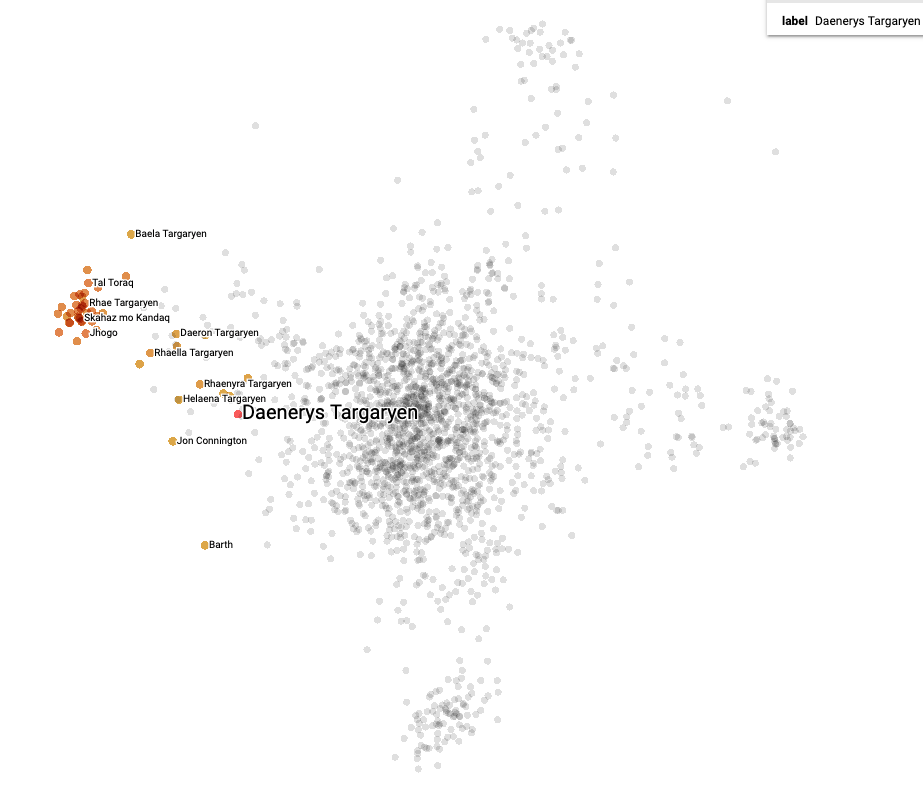

Note, I spoke to Minh and showed him that Ampligraph continuously crashed my local python kernel and that TensorBoard cannot display projections on Google Colab. In the interest of not wasting lots of "project time" in fixing a small error he said I could submit just the image from the tutorial and would not be penalized by it, as it was preferrable to allocate the time elsewhere.

## Training a model (TransE)

In [30]:
from ampligraph.latent_features import TransE

model = TransE(batches_count=100, 
                seed=0, 
                epochs=200, 
                k=150, 
                eta=5,
                optimizer='adam', 
                optimizer_params={'lr':1e-3},
                loss='multiclass_nll', 
                regularizer='LP', 
                regularizer_params={'p':3, 'lambda':1e-5}, 
                verbose=True)

positives_filter = X

tf.logging.set_verbosity(tf.logging.ERROR)

model.fit(X_train, early_stopping = False)

ranks = evaluate_performance(X_test, 
                             model=model, 
                             filter_triples=positives_filter,   # Corruption strategy filter defined above 
                             use_default_protocol=True, # corrupt subj and obj separately while evaluating
                             verbose=True)

model_comparison['TransE'] = {}
model_comparison['TransE']['MMR'] = mrr_score(ranks)
print("MRR: %.2f" % (model_comparison['TransE']['MMR']))

model_comparison['TransE']['Hits@10'] = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (model_comparison['TransE']['Hits@10']))
model_comparison['TransE']['Hits@3'] = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (model_comparison['TransE']['Hits@3']))
model_comparison['TransE']['Hits@1'] = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (model_comparison['TransE']['Hits@1']))

Average Loss:   0.017881: 100%|██████████| 200/200 [01:49<00:00,  1.82epoch/s]

WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.



100%|██████████| 100/100 [00:00<00:00, 178.01it/s]


MRR: 0.20
Hits@10: 0.36
Hits@3: 0.24
Hits@1: 0.12


## Training a model (DistMult)

In [31]:
from ampligraph.latent_features import DistMult

model = DistMult(batches_count=100, 
                seed=0, 
                epochs=200, 
                k=150, 
                eta=5,
                optimizer='adam', 
                optimizer_params={'lr':1e-3},
                loss='multiclass_nll', 
                regularizer='LP', 
                regularizer_params={'p':3, 'lambda':1e-5}, 
                verbose=True)

positives_filter = X

tf.logging.set_verbosity(tf.logging.ERROR)

model.fit(X_train, early_stopping = False)

ranks = evaluate_performance(X_test, 
                             model=model, 
                             filter_triples=positives_filter,   # Corruption strategy filter defined above 
                             use_default_protocol=True, # corrupt subj and obj separately while evaluating
                             verbose=True)

model_comparison['DistMult'] = {}
model_comparison['DistMult']['MMR'] = mrr_score(ranks)
print("MRR: %.2f" % (model_comparison['DistMult']['MMR']))

model_comparison['DistMult']['Hits@10'] = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (model_comparison['DistMult']['Hits@10']))
model_comparison['DistMult']['Hits@3'] = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (model_comparison['DistMult']['Hits@3']))
model_comparison['DistMult']['Hits@1'] = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (model_comparison['DistMult']['Hits@1']))

Average Loss:   0.016550: 100%|██████████| 200/200 [01:54<00:00,  1.74epoch/s]

WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.



100%|██████████| 100/100 [00:00<00:00, 172.32it/s]


MRR: 0.39
Hits@10: 0.54
Hits@3: 0.43
Hits@1: 0.31


In [32]:
import pandas as pd
results = pd.DataFrame(model_comparison)
results

,ComplEx,TransE,DistMult
MMR,0.413934,0.199833,0.393764
Hits@10,0.550000,0.365000,0.540000
Hits@3,0.445000,0.240000,0.435000
Hits@1,0.340000,0.120000,0.310000


<br> #1 Model: ComplEx
<br> #2 Model: DistMult
<br> #3 Model: TransE